In [1]:
import os
import numpy as np
import pandas as pd

# Exemple : dictionnaire des plages pour chaque minéral (à adapter avec tes vraies données)
mineral_property_ranges = {
    'azurite': (3.5, 4.0, 3.77, 3.77),
    'copper': (2.5, 3.0, 8.9, 8.9),
    'galena': (2.5, 2.5, 7.6, 7.6),
    'gold': (2.5, 3.0, 15.0, 19.3),
    'hematite': (5.0, 6.0, 5.26, 5.26),
    'limonite': (4.0, 5.5, 2.7, 4.3),
    'magnetite': (5.5, 6.5, 5.175, 5.175),
    'opal': (5.5, 6.5, 1.9, 2.3),
    'pyrit': (6.0, 6.5, 4.8, 5.0),
    'quartz': (7.0, 7.0, 2.6, 2.6),
    'saphir': (9.0, 9.0, 3.98, 4.06),
    'schwefel': (1.5, 2.5, 2.07, 2.07)
}

# Encodage des étiquettes
label_to_index = {name: idx for idx, name in enumerate(mineral_property_ranges.keys())}


def load_data(data_dir, output_csv="data_test.csv", seed=42):
    np.random.seed(seed)
    dict_mineral = []

    for mineral, (min_h, max_h, min_d, max_d) in mineral_property_ranges.items():
        class_dir = os.path.join(data_dir, mineral)

        if not os.path.isdir(class_dir):
            print(f"Dossier manquant : {class_dir}")
            continue

        for file in os.listdir(class_dir):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(class_dir, file)

                hardness = np.random.uniform(min_h, max_h)
                density = np.random.uniform(min_d, max_d)

                dict_mineral.append({
                    "image_path": image_path,
                    "mineral": mineral,
                    "durete": round(hardness, 2),
                    "densite": round(density, 2)
                })

    # Conversion en DataFrame
    df = pd.DataFrame(dict_mineral)

    # Export en CSV
    df.to_csv(output_csv, index=False)
    print(f"Fichier CSV généré : {output_csv}")
    
    return df  # Utile si tu veux l'explorer directement


# 🔁 Exemple d'appel :
# df = load_data("chemin/vers/tes/images/")


In [2]:
df = load_data('C:/Users/dembe/Desktop/projet_minerai/datatest')

Fichier CSV généré : data_test.csv


In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import joblib
import os

# === Chargement des composants ===/
model = tf.keras.models.load_model('model_final_durete_densiter.h5')
scaler = joblib.load('scaler.pkl')
label_encoder = joblib.load('label_encoder.pkl')

# === Paramètres d'image ===
IMG_SIZE = (380, 380)  

# === Prétraitement de l’image ===
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMG_SIZE)
    img = img.astype(np.float32) / 255.0
    return img

# Fonction 1 : Prédiction batch depuis un fichier CSV 
def predict_batch(csv_path):
    df = pd.read_csv(csv_path)
    images = []
    tabular_data = []

    for _, row in df.iterrows():
        image = preprocess_image(row['image_path'])
        images.append(image)
        tabular_data.append([row['durete'], row['densite']])

    X_img = np.array(images)
    X_tab = scaler.transform(np.array(tabular_data))

    predictions = model.predict([X_img, X_tab])
    predicted_classes = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

    df['prediction'] = predicted_classes
    return df[['mineral', 'prediction']]



C:\Users\dembe\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
df_result = predict_batch("data_test.csv")

C:\Users\dembe\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 314s 16s/step


In [11]:
df_correct = df_result['mineral'] == df_result['prediction']

In [12]:
df_correct.sum()

562

In [13]:
df_faux= df_result['mineral'] != df_result['prediction']

In [14]:
df_faux.sum()

38

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Vecteurs de vérité et prédictions
y_true = label_encoder.transform(df_result['mineral'])
y_pred = label_encoder.transform(df_result['prediction'])

# 2. Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy : {accuracy:.2%}")

# 3. Rapport complet
print("\nClassification Report :")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


Accuracy : 93.67%

Classification Report :
              precision    recall  f1-score   support

     azurite       0.96      1.00      0.98        50
      copper       1.00      1.00      1.00        50
      galena       1.00      1.00      1.00        50
        gold       1.00      1.00      1.00        50
    hematite       0.66      0.78      0.72        50
    limonite       1.00      0.96      0.98        50
   magnetite       0.69      0.50      0.58        50
        opal       1.00      1.00      1.00        50
       pyrit       0.91      1.00      0.95        50
      quartz       1.00      1.00      1.00        50
      saphir       1.00      1.00      1.00        50
    schwefel       1.00      1.00      1.00        50

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.93       600
weighted avg       0.94      0.94      0.93       600



<Figure size 1200x1000 with 0 Axes>

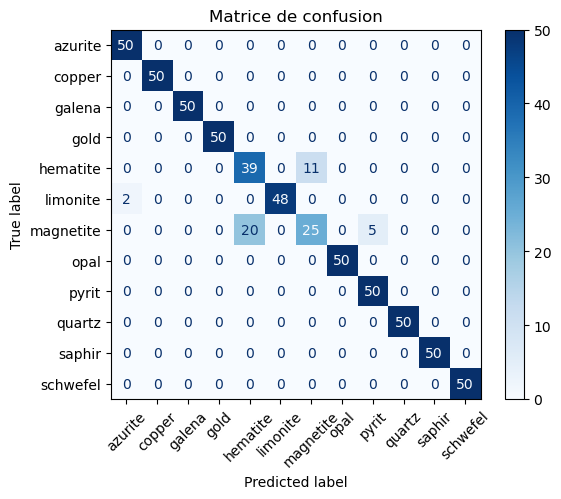

In [16]:
# 4. Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(12, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Matrice de confusion")
plt.grid(False)
plt.show()